In [14]:
import numpy as np
import pandas as pd
from scipy.stats import norm

class SyntheticWearablePHQGenerator:
    def __init__(
        self,
        n_samples=10000,
        imbalance_ratio=0.5,
        noise_scale=0.1,
        missing_rate=0.0,
        random_state=42,
    ):
        self.n_samples = n_samples
        self.imbalance_ratio = imbalance_ratio
        self.noise_scale = noise_scale
        self.missing_rate = missing_rate
        self.random_state = random_state
        np.random.seed(self.random_state)

        # Spearman correlations from paper (used as target monotonic associations)
        self.correlations = {
            # Heart rate metrics
            "DHRb.cvc": 0.121,
            "NHRd.0204.sde":  0.450,  #0.262,
            "NHR.0204.cv":   0.450, ##0.257,
            "NHR.0406.sd": 0.182,
            "NHR.0406.cv": 0.185,
            "NHR.0002.sd": 0.149,
            "NHR.0002.cv": 0.138,

            # Circadian (nonparametric)
            "ISf.stg.wdh": -0.165,
            "IS.hri.wd": -0.199,
            "ACj.st.60mk": -0.125,
            "AC.st.15m": -0.175,
            "AC.st.30m": -0.155,
            "AC.st.60m.wd": -0.159,
            "AC.st.15m.wd": -0.177,
            "AC.st.30m.wd": -0.177,
            "AC.hr.60m.wd": -0.150,
            "AC.hr.30m.wd": -0.144,
            "ICVl.st.wd": 0.176,
            "ICV.hr": 0.177,
            "ICV.hr.wd": 0.237,
            "peaks.st": -0.205,
            "peaks.st.wd": -0.45,#-0.202,

            # Circadian (cosinor)
            "acrom.st": 0.133,
            "F.st.wd": -0.121,
            "beta.hr": 0.169,
            "acro.hr": 0.146,
            "F.hr": -0.126,
            "beta.hr.wd": 0.126,
            "acro.hr.wd": 0.154,
            "F.hr.wd": -0.137,

            # Sleep metrics
            "sleep.offset": 0.144,
            "sleep.midpoint": 0.172,
            "sleep.offset.wd": 0.134,
            "sleep.offset.wd.sd": 0.199,
            "sleep.midpoint.wd": 0.146,
            "sleep.midpoint.wd.sd": 0.146,
        }

    def _generate_phq(self):
        """Generate PHQ scores with controllable mixture (for realistic marginal distribution)."""
        depressed_count = int(self.n_samples * self.imbalance_ratio)
        non_depressed_count = self.n_samples - depressed_count

        phq_low = np.random.normal(5, 2, non_depressed_count)
        phq_high = np.random.normal(16, 4, depressed_count)

        phq = np.concatenate([phq_low, phq_high])
        phq = np.clip(phq, 0, 27)
        np.random.shuffle(phq)
        return phq

    def _generate_feature(self, phq, rho):
        """Generate a feature with approximate Spearman rho vs PHQ (via Gaussian copula)."""
        z_phq = norm.ppf((phq + 0.01) / 27.01)
        epsilon = np.random.normal(size=len(phq))

        z_feature = rho * z_phq + np.sqrt(max(1e-12, 1 - rho**2)) * epsilon
        z_feature += self.noise_scale * np.random.normal(size=len(phq))

        # Convert to [0,1] via CDF so all features are comparable
        feature = norm.cdf(z_feature)
        return feature

    def generate(self):
        phq = self._generate_phq()
        data = pd.DataFrame({"phq_score": phq})

        for feature_name, rho in self.correlations.items():
            data[feature_name] = self._generate_feature(phq, rho)

        # Introduce missingness ONLY in wearable features (keep PHQ fully observed by default)
        if self.missing_rate > 0:
            feat_cols = [c for c in data.columns if c != "phq_score"]
            mask = np.random.rand(data.shape[0], len(feat_cols)) < self.missing_rate
            data.loc[:, feat_cols] = data.loc[:, feat_cols].mask(mask)

        return data

    def save(self, filename="synthetic_wearable_phq_full.csv"):
        df = self.generate()
        df.to_csv(filename, index=False)
        print(f"Dataset saved to {filename}")


if __name__ == "__main__":
    generator = SyntheticWearablePHQGenerator(
        n_samples=10000,
        imbalance_ratio=0.75,
        noise_scale=0.01,
        missing_rate=0.01,
        random_state=42,
    )
    generator.save()


Dataset saved to synthetic_wearable_phq_full.csv


Loaded: synthetic_wearable_phq_full.csv
Shape: (10000, 37)
Columns: ['phq_score', 'DHRb.cvc', 'NHRd.0204.sde', 'NHR.0204.cv', 'NHR.0406.sd', 'NHR.0406.cv', 'NHR.0002.sd', 'NHR.0002.cv', 'ISf.stg.wdh', 'IS.hri.wd', 'ACj.st.60mk', 'AC.st.15m', 'AC.st.30m', 'AC.st.60m.wd', 'AC.st.15m.wd', 'AC.st.30m.wd', 'AC.hr.60m.wd', 'AC.hr.30m.wd', 'ICVl.st.wd', 'ICV.hr', 'ICV.hr.wd', 'peaks.st', 'peaks.st.wd', 'acrom.st', 'F.st.wd', 'beta.hr', 'acro.hr', 'F.hr', 'beta.hr.wd', 'acro.hr.wd', 'F.hr.wd', 'sleep.offset', 'sleep.midpoint', 'sleep.offset.wd', 'sleep.offset.wd.sd', 'sleep.midpoint.wd', 'sleep.midpoint.wd.sd']

Dtypes (first 10):
phq_score        float64
DHRb.cvc         float64
NHRd.0204.sde    float64
NHR.0204.cv      float64
NHR.0406.sd      float64
NHR.0406.cv      float64
NHR.0002.sd      float64
NHR.0002.cv      float64
ISf.stg.wdh      float64
IS.hri.wd        float64
dtype: object

Head:


,phq_score,DHRb.cvc,NHRd.0204.sde,NHR.0204.cv,NHR.0406.sd,NHR.0406.cv,NHR.0002.sd,NHR.0002.cv,ISf.stg.wdh,IS.hri.wd,...,F.hr,beta.hr.wd,acro.hr.wd,F.hr.wd,sleep.offset,sleep.midpoint,sleep.offset.wd,sleep.offset.wd.sd,sleep.midpoint.wd,sleep.midpoint.wd.sd
0,18.761891,0.349296,0.547996,0.078951,0.784104,0.534811,0.784097,0.711160,0.733076,0.830866,...,0.788637,0.786766,0.471818,0.198517,0.726496,0.984417,0.657147,0.899997,0.093704,0.098989
1,22.503836,0.521029,0.496712,0.377088,0.671337,0.262574,0.803436,0.997933,0.228408,0.185827,...,0.258480,0.210198,0.702793,0.097918,0.441273,0.033686,0.782561,0.914155,0.637998,0.903396
2,14.426596,0.343505,0.657582,0.469793,0.022191,NaN,0.602225,0.648000,0.884851,0.850509,...,0.407882,0.931420,0.595594,0.492978,0.335914,0.959954,0.782310,0.251995,0.932156,0.465761
3,4.607300,0.180261,0.358065,0.090077,0.311715,0.121900,0.318265,0.511662,0.404810,0.654533,...,0.133984,0.682207,0.636411,0.369927,0.969822,0.154134,0.954662,0.949561,0.086246,0.374947
4,10.825969,0.752544,0.614804,0.301469,0.395024,0.286288,0.589048,0.538857,0.601256,0.754412,...,0.400102,0.580603,0.269026,0.130822,0.484989,0.869492,0.120978,0.669389,0.921080,0.800038



Top missingness rates:
NHR.0406.sd             1.13%
F.hr                     1.1%
ICV.hr.wd               1.09%
ACj.st.60mk             1.09%
ICVl.st.wd              1.09%
beta.hr.wd              1.09%
NHR.0406.cv             1.08%
AC.st.15m               1.08%
beta.hr                 1.07%
acro.hr.wd              1.07%
NHR.0002.sd             1.06%
sleep.midpoint.wd.sd    1.05%
sleep.offset.wd.sd      1.05%
NHR.0204.cv             1.04%
AC.st.30m.wd            1.03%
dtype: object

PHQ score summary:
count    10000.000
mean        13.222
std          5.939
min          0.000
25%          7.981
50%         14.211
75%         17.666
max         27.000
Name: phq_score, dtype: float64

Derived severity distribution (from PHQ only):
phq_score
Medium (10-19)    5552
Low (0-9)         2776
Severe (20-27)    1672
Name: count, dtype: int64
phq_score
Medium (10-19)    55.52
Low (0-9)         27.76
Severe (20-27)    16.72
Name: pct, dtype: float64


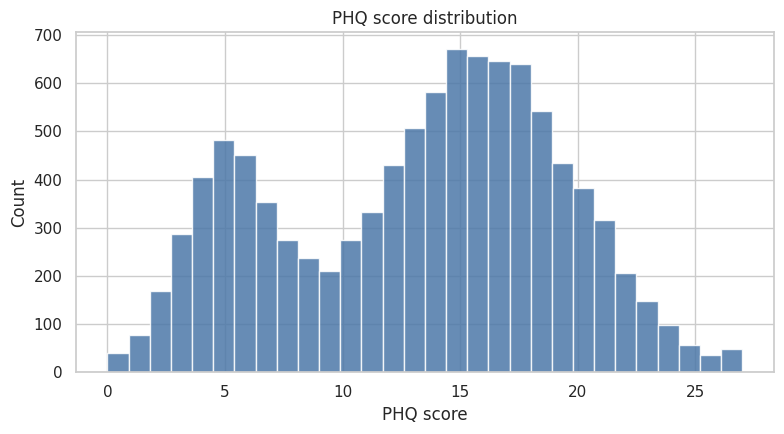

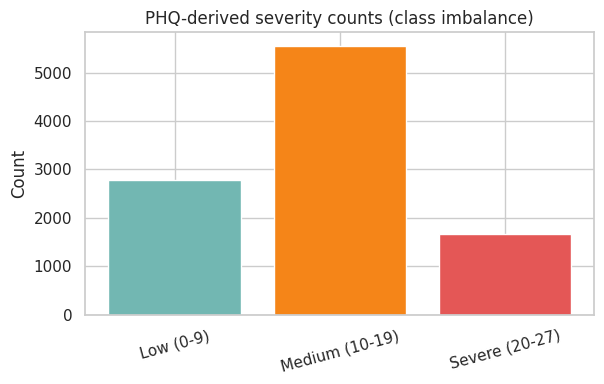

Severity counts:
 phq_score
Low (0-9)         2776
Medium (10-19)    5552
Severe (20-27)    1672
Name: count, dtype: int64
Severity %:
 phq_score
Low (0-9)         27.76
Medium (10-19)    55.52
Severe (20-27)    16.72
Name: count, dtype: float64

Proposed regression sample weights (inverse-frequency by severity bin):
{0: 1.2007684918347743, 1: 0.6003842459173871, 2: 1.9936204146730463}


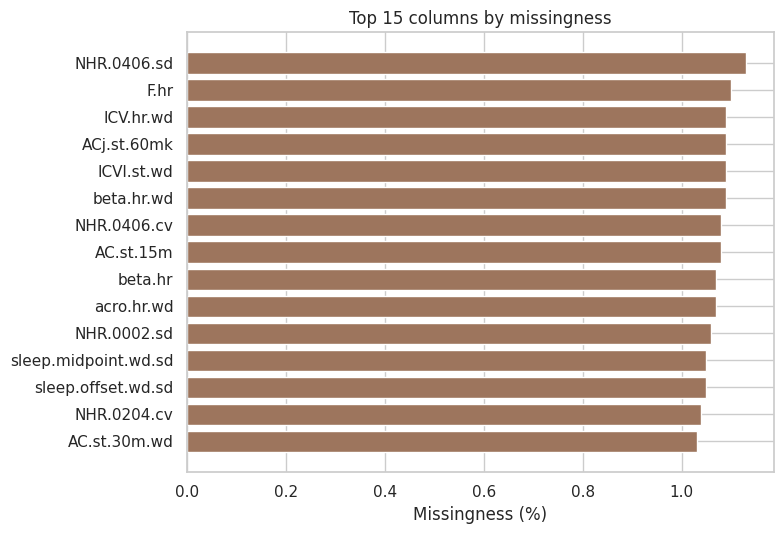

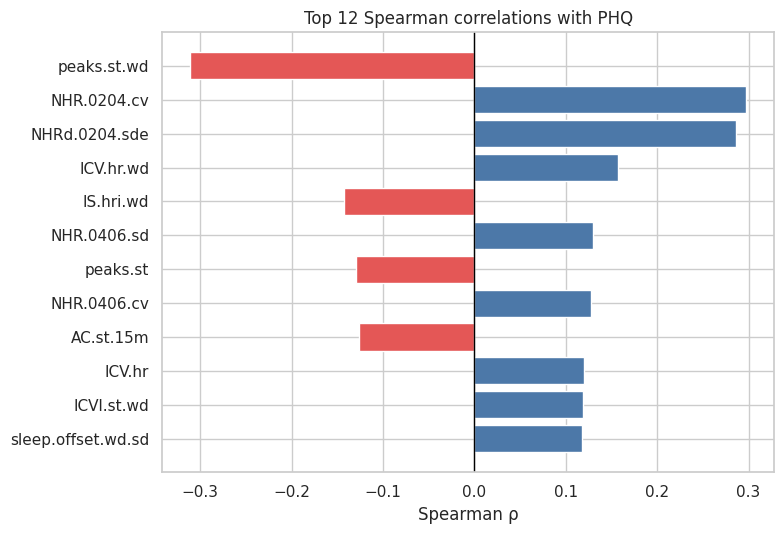

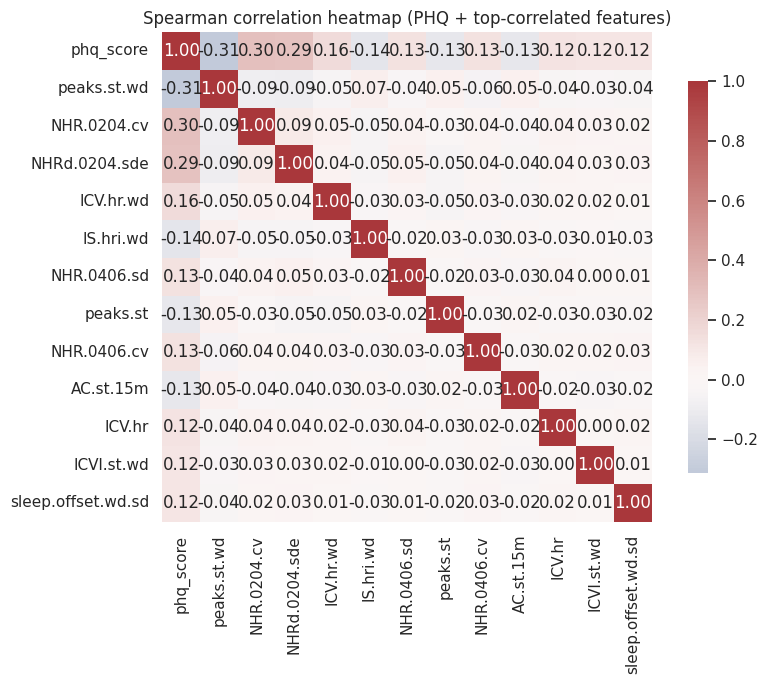

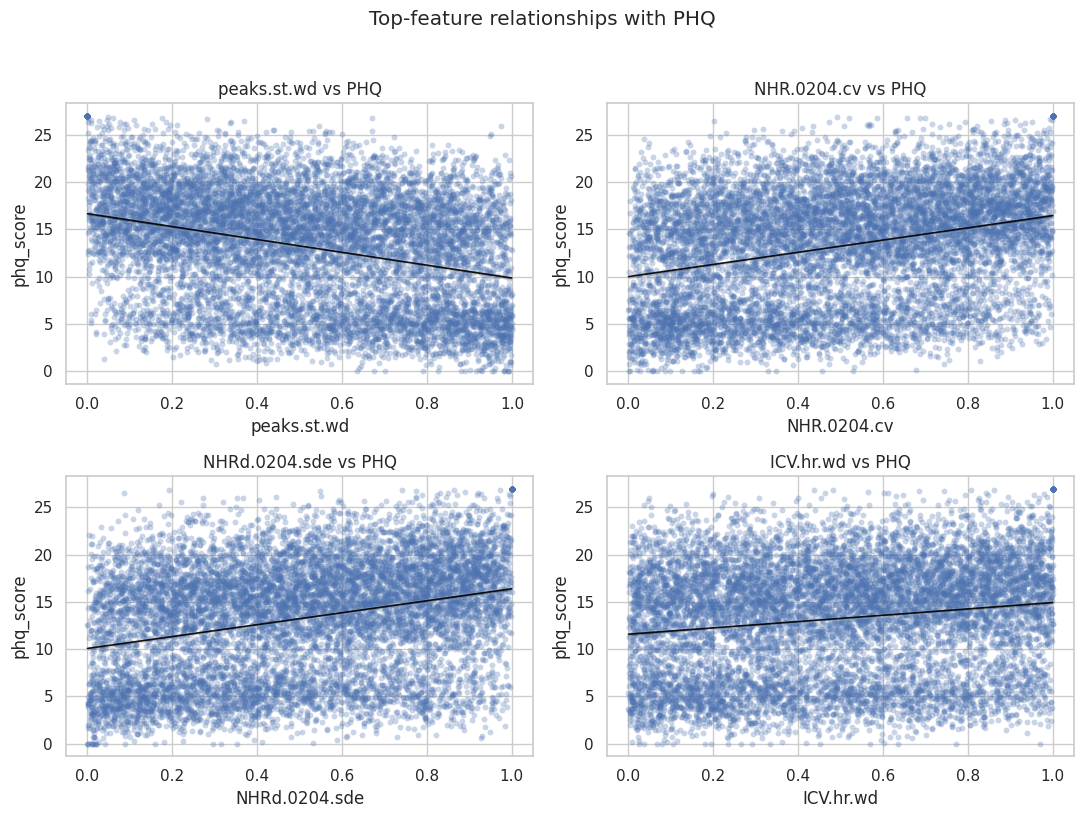


Top Spearman correlations with PHQ (absolute):
peaks.st.wd          -0.311
NHR.0204.cv           0.297
NHRd.0204.sde         0.287
ICV.hr.wd             0.157
IS.hri.wd            -0.143
NHR.0406.sd           0.130
peaks.st             -0.130
NHR.0406.cv           0.127
AC.st.15m            -0.127
ICV.hr                0.120
ICVl.st.wd            0.119
sleep.offset.wd.sd    0.118
AC.st.30m.wd         -0.115
NHR.0002.sd           0.113
AC.st.15m.wd         -0.111
Name: phq_score, dtype: float64


In [15]:
# Load the generated synthetic dataset and do quick sanity/EDA summaries
import pandas as pd
import numpy as np

path = "synthetic_wearable_phq_full.csv"
df2 = pd.read_csv(path)

print("Loaded:", path)
print("Shape:", df2.shape)
print("Columns:", list(df2.columns))

print("\nDtypes (first 10):")
print(df2.dtypes.head(10))

print("\nHead:")
display(df2.head())

# Missingness
na_rate = df2.isna().mean().sort_values(ascending=False)
print("\nTop missingness rates:")
print((na_rate.head(15) * 100).round(2).astype(str) + "%")

# Target distribution
print("\nPHQ score summary:")
print(df2["phq_score"].describe().round(3))

# Optional: derived severity bins (from PHQ only; no saved threshold-based label)
sev = pd.cut(
    df2["phq_score"],
    bins=[-0.001, 9, 19, 27],
    labels=["Low (0-9)", "Medium (10-19)", "Severe (20-27)"],
)
print("\nDerived severity distribution (from PHQ only):")
print(sev.value_counts(dropna=False).rename("count"))
print((sev.value_counts(normalize=True, dropna=False) * 100).round(2).rename("pct"))

# EDA plots for the synthetic wearable+PHQ dataset
# Updated to (a) not rely on a saved `depressed` label and (b) quantify PHQ imbalance + propose weights

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use df2 if it exists; otherwise load from disk
if "df2" in globals() and isinstance(df2, pd.DataFrame):
    df_eda = df2.copy()
else:
    df_eda = pd.read_csv("synthetic_wearable_phq_full.csv")

sns.set_theme(style="whitegrid")

# ------------------------------
# 1) PHQ score distribution
# ------------------------------
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
phq = df_eda["phq_score"].dropna()
ax.hist(phq, bins=30, color="#4C78A8", alpha=0.85, edgecolor="white")
ax.set_title("PHQ score distribution")
ax.set_xlabel("PHQ score")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# ------------------------------
# 2) Derived 3-level severity (imbalance view)
# ------------------------------
sev = pd.cut(
    df_eda["phq_score"],
    bins=[-0.001, 9, 19, 27],
    labels=["Low (0-9)", "Medium (10-19)", "Severe (20-27)"],
)
sev_counts = sev.value_counts().reindex(["Low (0-9)", "Medium (10-19)", "Severe (20-27)"])

fig, ax = plt.subplots(1, 1, figsize=(6.2, 4.0))
ax.bar(sev_counts.index, sev_counts.values, color=["#72B7B2", "#F58518", "#E45756"], edgecolor="white")
ax.set_title("PHQ-derived severity counts (class imbalance)")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=15)
plt.tight_layout()
plt.show()

print("Severity counts:\n", sev_counts)
print("Severity %:\n", (sev_counts / sev_counts.sum() * 100).round(2))

# Create a simple inverse-frequency sample-weight vector for regression
# (heavier weight on Medium/Severe PHQ ranges)
sev_to_int = {"Low (0-9)": 0, "Medium (10-19)": 1, "Severe (20-27)": 2}
sev_int = sev.map(sev_to_int)
class_freq = sev_int.value_counts(dropna=True).sort_index()
class_w = (class_freq.sum() / (len(class_freq) * class_freq)).to_dict()  # normalized inverse frequency

# Per-row sample weight (NaN PHQ gets NaN weight)
sample_weight_reg = sev_int.map(class_w)

print("\nProposed regression sample weights (inverse-frequency by severity bin):")
print({k: float(v) for k, v in class_w.items()})

# ------------------------------
# 3) Missingness rates (top 15)
# ------------------------------
na_rate = df_eda.isna().mean().sort_values(ascending=False)
na_top = na_rate.head(15)[::-1]

fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
ax.barh(na_top.index, na_top.values * 100, color="#9D755D")
ax.set_title("Top 15 columns by missingness")
ax.set_xlabel("Missingness (%)")
plt.tight_layout()
plt.show()

# ------------------------------
# 4) Correlation with PHQ (Spearman) + heatmap for top features
# ------------------------------
num_cols = df_eda.select_dtypes(include=[np.number]).columns
feature_cols = [c for c in num_cols if c != "phq_score"]

spearman_vs_phq = df_eda[feature_cols + ["phq_score"]].corr(method="spearman")["phq_score"].drop("phq_score")
spearman_sorted = spearman_vs_phq.sort_values(key=lambda s: s.abs(), ascending=False)

topk = 12
Top = spearman_sorted.head(topk)

fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
colors = np.where(Top.values >= 0, "#4C78A8", "#E45756")
ax.barh(Top.index[::-1], Top.values[::-1], color=colors[::-1])
ax.axvline(0, color="black", linewidth=1)
ax.set_title(f"Top {topk} Spearman correlations with PHQ")
ax.set_xlabel("Spearman ρ")
plt.tight_layout()
plt.show()

heat_cols = ["phq_score"] + list(Top.index)
corr_mat = df_eda[heat_cols].corr(method="spearman")

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
sns.heatmap(
    corr_mat,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax,
)
ax.set_title("Spearman correlation heatmap (PHQ + top-correlated features)")
plt.tight_layout()
plt.show()

# ------------------------------
# 5) Relationship plots for a few top features (no label coloring)
# ------------------------------
rel_features = list(Top.index[:4])
df_rel = df_eda[["phq_score"] + rel_features].copy()

fig, axes = plt.subplots(2, 2, figsize=(11, 8), sharey=False)
axes = axes.ravel()

for ax, col in zip(axes, rel_features):
    sns.scatterplot(
        data=df_rel,
        x=col,
        y="phq_score",
        alpha=0.30,
        s=18,
        linewidth=0,
        ax=ax,
    )
    sns.regplot(
        data=df_rel,
        x=col,
        y="phq_score",
        scatter=False,
        ci=95,
        color="black",
        line_kws={"linewidth": 1.2, "alpha": 0.9},
        ax=ax,
    )
    ax.set_title(f"{col} vs PHQ")

fig.suptitle("Top-feature relationships with PHQ", y=1.02)
plt.tight_layout()
plt.show()

print("\nTop Spearman correlations with PHQ (absolute):")
print(spearman_sorted.head(15).round(3))



Loaded dataset: (10000, 37)
Training complete.

====== FINAL PHQ REGRESSION RESULTS ======
R2   : 0.3795
MAE  : 3.8719
RMSE : 4.7431


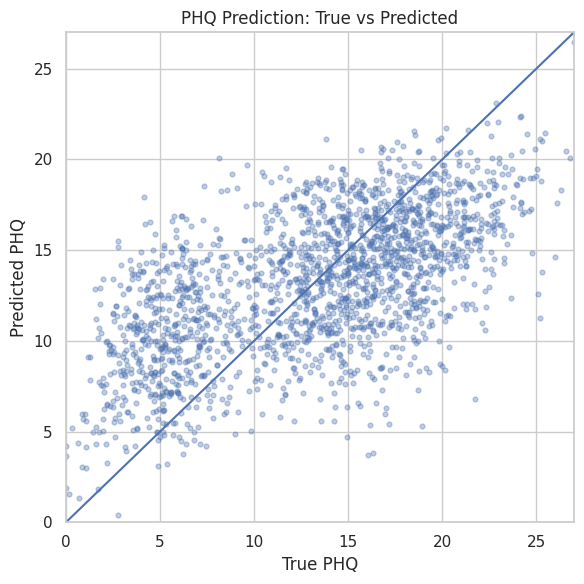

In [17]:
# ============================================================
# FINAL PHQ SCORE PREDICTION PIPELINE (XGBoost ≥ 2.0 Compatible)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor

# ------------------------------------------------------------
# 1) Load Dataset
# ------------------------------------------------------------

DATA_PATH = "synthetic_wearable_phq_full.csv"
df = pd.read_csv(DATA_PATH)

TARGET = "phq_score"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

print("Loaded dataset:", df.shape)

# ------------------------------------------------------------
# 2) Preprocessing (NO scaling for trees)
# ------------------------------------------------------------

num_features = X.select_dtypes(include=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline([
                ("impute", SimpleImputer(strategy="median")),
            ]),
            num_features,
        )
    ],
    remainder="drop",
)

# ------------------------------------------------------------
# 3) Optimized XGBoost Model
# ------------------------------------------------------------

model = XGBRegressor(
    n_estimators=4000,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    gamma=0.1,
    reg_alpha=0.05,
    reg_lambda=1.5,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

phq_reg_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", model),
])

# ------------------------------------------------------------
# 4) Train / Validation / Test Split
# ------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# 5) Severity-Based Sample Weights
# ------------------------------------------------------------

sev_tr = pd.cut(
    y_tr,
    bins=[-0.001, 9, 19, 27],
    labels=[0, 1, 2]
).astype(int)

class_freq = sev_tr.value_counts().sort_index()
class_weights = (class_freq.sum() / (len(class_freq) * class_freq)).to_dict()
sample_weights = sev_tr.map(class_weights).to_numpy()

# ------------------------------------------------------------
# 6) MANUAL PREPROCESSING FOR EARLY STOPPING (IMPORTANT FIX)
# ------------------------------------------------------------

# Fit preprocess separately
X_tr_proc = preprocess.fit_transform(X_tr)
X_val_proc = preprocess.transform(X_val)
X_test_proc = preprocess.transform(X_test)

# Fit model directly (not through pipeline)
model.fit(
    X_tr_proc,
    y_tr,
    sample_weight=sample_weights,
    eval_set=[(X_val_proc, y_val)],
    verbose=False,
)

print("Training complete.")

# ------------------------------------------------------------
# 7) Evaluate
# ------------------------------------------------------------

y_pred = model.predict(X_test_proc)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n====== FINAL PHQ REGRESSION RESULTS ======")
print(f"R2   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

# ------------------------------------------------------------
# 8) Visualization
# ------------------------------------------------------------

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, s=12, alpha=0.35)
plt.plot([0, 27], [0, 27])
plt.xlim(0, 27)
plt.ylim(0, 27)
plt.xlabel("True PHQ")
plt.ylabel("Predicted PHQ")
plt.title("PHQ Prediction: True vs Predicted")
plt.tight_layout()
plt.show()